In [1]:
# general libraries
import warnings
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from collections import Counter
warnings.filterwarnings("ignore")

# visualization
import seaborn as sns
import matplotlib.pyplot as plt

from geopy import distance

In [2]:
# cc_fraud = pd.read_csv('../data/full_fraud_dataset.csv',nrows=100000)
cc_fraud = pd.read_csv('data/group2.csv',nrows=100000)
cc_fraud['full_name'] = cc_fraud['first'] + ' ' + cc_fraud['last']
print(cc_fraud.shape)

(100000, 26)


In [3]:
cc_fraud['trans_time'] =  pd.to_datetime(cc_fraud['trans_time'], format='%H:%M:%S').dt.strftime('%H:%M:%S')

In [4]:
to_drop = ['ssn', 'first', 'last', 'street', 'state', 'zip','unix_time']
cc_clean = cc_fraud.drop(to_drop, axis=1)

In [5]:
# pre-processing time
# transaction date
cc_clean['trans_datetime'] = pd.to_datetime(cc_clean['trans_date'])
cc_clean['trans_date'] = cc_clean['trans_datetime'].dt.date
cc_clean['trans_year'] = cc_clean['trans_datetime'].dt.year.astype(str)
cc_clean['trans_month'] = cc_clean['trans_datetime'].dt.month
cc_clean['trans_day'] = cc_clean['trans_datetime'].dt.day

# transaction time
cc_clean['trans_hour'] = cc_clean['trans_time'].str[:2].astype(int)

# convert month to string
month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun',
             7: 'Jul', 8: 'Aug', 9: 'Sep', 10:'Oct', 11:'Nov', 12:'Dec'}
cc_clean['trans_month_'] = cc_clean['trans_month'].map(month_map)

# convert time to part of day
def get_part_of_day(hour):
    """Return the part of day given the hour of day"""
    if (hour > 22) or (hour <= 6):
        return 'early morning'
    elif hour <= 11:
        return 'breakfast'
    elif hour <= 14:
        return 'lunch'
    elif hour <= 17:
        return 'afternoon'
    else:
        return 'dinner'
cc_clean.loc[:, 'part_of_day'] = cc_clean['trans_hour'].apply(get_part_of_day)

cc_clean['dob_datetime'] = pd.to_datetime(cc_clean['dob'])
cc_clean['dob'] = cc_clean['dob_datetime'].dt.date
cc_clean['age'] = (cc_clean['trans_date'] - cc_clean['dob'])/365
cc_clean['age'] = cc_clean['age'].apply(lambda x: x.days)

In [6]:
cc_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 28 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   cc_num          100000 non-null  float64       
 1   gender          100000 non-null  object        
 2   city            100000 non-null  object        
 3   lat             100000 non-null  float64       
 4   long            100000 non-null  float64       
 5   city_pop        100000 non-null  int64         
 6   job             100000 non-null  object        
 7   dob             100000 non-null  object        
 8   acct_num        100000 non-null  float64       
 9   trans_num       100000 non-null  object        
 10  trans_date      100000 non-null  object        
 11  trans_time      100000 non-null  object        
 12  category        100000 non-null  object        
 13  amt             100000 non-null  float64       
 14  is_fraud        100000 non-null  int6

#### transactions 

In [7]:
## formatting full_datetime
transaction_dt = cc_clean[['full_name', 'acct_num', 'cc_num', 'trans_num', 'category', 'is_fraud', 'trans_date', 'trans_time']].sort_values(['full_name', 'trans_date', 'trans_time'])
transaction_dt['full_datetime'] = pd.to_datetime(pd.to_datetime(transaction_dt['trans_date'], format='%Y-%m-%d').dt.strftime('%Y-%m-%d') + transaction_dt['trans_time'], format='%Y-%m-%d%H:%M:%S')
transaction_dt.head()

,full_name,acct_num,cc_num,trans_num,category,is_fraud,trans_date,trans_time,full_datetime
50031,Aaron Chase,1.960530e+11,3.481480e+14,4f8a962f3dddc9f7e38511742f94f5c6,kids_pets,0,2020-01-01,22:20:55,2020-01-01 22:20:55
50792,Aaron Chase,1.960530e+11,3.481480e+14,d6f7186ff825d376de337b0736a8df51,misc_pos,0,2020-01-02,05:58:15,2020-01-02 05:58:15
50148,Aaron Chase,1.960530e+11,3.481480e+14,d369c21bde01d8936664b60ffe249966,shopping_pos,0,2020-01-02,06:20:53,2020-01-02 06:20:53
50332,Aaron Chase,1.960530e+11,3.481480e+14,449355d3afc7fbc8a0a9c4331b01baa0,personal_care,0,2020-01-02,19:30:42,2020-01-02 19:30:42
50709,Aaron Chase,1.960530e+11,3.481480e+14,99aa7b2fd8e3f8ed852fcd2736523ec4,kids_pets,0,2020-01-02,21:16:56,2020-01-02 21:16:56


In [8]:
# getting the first transaction per person
min_datetime = pd.DataFrame(transaction_dt.groupby(['full_name'])['full_datetime'].min()).reset_index()
min_datetime = min_datetime.rename(columns={'full_datetime':'min_datetime'})
min_datetime.shape

(90, 2)

In [9]:
## get time between transactions (regardless of fraud status)
transaction_dt = transaction_dt.merge(min_datetime, how = 'left', on = 'full_name')
transaction_dt['lagged_datetime'] = transaction_dt.groupby(['full_name'])['full_datetime'].shift(1)
transaction_dt['diff_datetime'] = (transaction_dt['full_datetime'] - transaction_dt['lagged_datetime'])
transaction_dt['diff_datetime_days'] = transaction_dt['diff_datetime'].astype('timedelta64[D]')
transaction_dt['diff_datetime_hrs'] = transaction_dt['diff_datetime'].astype('timedelta64[h]')
transaction_dt['diff_datetime_mins'] = transaction_dt['diff_datetime'].astype('timedelta64[m]')
transaction_dt

,full_name,acct_num,cc_num,trans_num,category,is_fraud,trans_date,trans_time,full_datetime,min_datetime,lagged_datetime,diff_datetime,diff_datetime_days,diff_datetime_hrs,diff_datetime_mins
0,Aaron Chase,1.960530e+11,3.481480e+14,4f8a962f3dddc9f7e38511742f94f5c6,kids_pets,0,2020-01-01,22:20:55,2020-01-01 22:20:55,2020-01-01 22:20:55,NaT,NaT,NaN,NaN,NaN
1,Aaron Chase,1.960530e+11,3.481480e+14,d6f7186ff825d376de337b0736a8df51,misc_pos,0,2020-01-02,05:58:15,2020-01-02 05:58:15,2020-01-01 22:20:55,2020-01-01 22:20:55,0 days 07:37:20,0.0,7.0,457.0
2,Aaron Chase,1.960530e+11,3.481480e+14,d369c21bde01d8936664b60ffe249966,shopping_pos,0,2020-01-02,06:20:53,2020-01-02 06:20:53,2020-01-01 22:20:55,2020-01-02 05:58:15,0 days 00:22:38,0.0,0.0,22.0
3,Aaron Chase,1.960530e+11,3.481480e+14,449355d3afc7fbc8a0a9c4331b01baa0,personal_care,0,2020-01-02,19:30:42,2020-01-02 19:30:42,2020-01-01 22:20:55,2020-01-02 06:20:53,0 days 13:09:49,0.0,13.0,789.0
4,Aaron Chase,1.960530e+11,3.481480e+14,99aa7b2fd8e3f8ed852fcd2736523ec4,kids_pets,0,2020-01-02,21:16:56,2020-01-02 21:16:56,2020-01-01 22:20:55,2020-01-02 19:30:42,0 days 01:46:14,0.0,1.0,106.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,Tristan Kirby,1.334290e+11,3.815670e+13,291c80502ee368630aab3a304092abcd,kids_pets,0,2021-12-07,13:15:21,2021-12-07 13:15:21,2020-01-02 16:26:18,2021-12-06 09:12:55,1 days 04:02:26,1.0,28.0,1682.0
99996,Tristan Kirby,1.334290e+11,3.815670e+13,f553f9399f2d51862f4caaa0549cea4d,travel,0,2021-12-07,17:35:47,2021-12-07 17:35:47,2020-01-02 16:26:18,2021-12-07 13:15:21,0 days 04:20:26,0.0,4.0,260.0
99997,Tristan Kirby,1.334290e+11,3.815670e+13,1cddbde4ad69eef5eb3be9e892948662,kids_pets,0,2021-12-09,22:37:17,2021-12-09 22:37:17,2020-01-02 16:26:18,2021-12-07 17:35:47,2 days 05:01:30,2.0,53.0,3181.0
99998,Tristan Kirby,1.334290e+11,3.815670e+13,0743a0401e9a32ad0445d9be1542d0bf,kids_pets,0,2021-12-10,23:44:56,2021-12-10 23:44:56,2020-01-02 16:26:18,2021-12-09 22:37:17,1 days 01:07:39,1.0,25.0,1507.0


##### consecutive fraud

In [10]:
names = transaction_dt['full_name'].unique()
x = pd.DataFrame()

for nm in names:
    y = transaction_dt[transaction_dt['full_name'] == nm]
    y['seq'] = y['is_fraud'].ne(y['is_fraud'].shift()).cumsum()

    x = pd.concat([x, y])
    # print("sequence col generated for user: " + nm)

In [11]:
# identify sequence of fraud
summary_x = x.groupby(['full_name','is_fraud']).value_counts(['seq']).reset_index()
summary_x = summary_x.rename(columns = {0:'seq_cnt'})
summary_x[summary_x['is_fraud']==1]['seq'].unique()

array([2, 4, 1], dtype=int64)

In [64]:
summary_x.sort_values(['full_name', 'seq']).head(30)

,full_name,is_fraud,seq,seq_cnt
1,Aaron Chase,0,1,1046
2,Aaron Chase,1,2,9
0,Aaron Chase,0,3,1047
4,Aaron Suarez,0,1,213
6,Aaron Suarez,1,2,7
5,Aaron Suarez,0,3,51
7,Aaron Suarez,1,4,3
3,Aaron Suarez,0,5,1141
8,Aaron Walker,1,1,10
10,Alex Alexander,0,1,275


##### creating new features

In [13]:
## 
transaction_dt['prev_fraud'] = transaction_dt.groupby(['full_name'])['is_fraud'].shift(1).fillna(0)
transaction_dt['prev_category'] = transaction_dt.groupby(['full_name'])['category'].shift(1)

In [14]:
# convert time to part of day
def get_hr_between_trans(hour):
    """Return the part of day given the hour of day"""
    if (hour > 24):
        return '> 24hrs'
    elif (hour <= 24) & (hour > 12):
        return '> 12hrs'
    elif (hour <= 12) & (hour > 6):
        return '> 6hrs'
    elif (hour <= 6) & (hour > 3):
        return '> 3hrs'
    elif (hour <= 3) & (hour > 1):
        return '> 1hr'
    else:
        return '<= 1hr'

transaction_dt['hrs_cat'] = transaction_dt['diff_datetime_hrs'].apply(get_hr_between_trans).fillna(0)

In [15]:
transaction_dt['hrs_cat'].value_counts()

<= 1hr     20393
> 6hrs     19121
> 12hrs    16992
> 3hrs     16012
> 1hr      14798
> 24hrs    12684
Name: hrs_cat, dtype: int64

In [16]:
transaction_dt = transaction_dt.merge(cc_clean[['full_name', 'trans_num', 'merchant', 'amt', \
    'city', 'lat', 'long', 'merch_lat', 'merch_long', 'city_pop', 'job', 'age']], on =['full_name','trans_num'], how = 'left')

In [17]:
transaction_dt['dist_to_merch_in_kms'] = transaction_dt.apply(lambda r: distance.distance((r['lat'], r['long']), (r['merch_lat'], r['merch_long'])).km, axis=1)

In [18]:
cc_clean.columns

Index(['cc_num', 'gender', 'city', 'lat', 'long', 'city_pop', 'job', 'dob',
       'acct_num', 'trans_num', 'trans_date', 'trans_time', 'category', 'amt',
       'is_fraud', 'merchant', 'merch_lat', 'merch_long', 'full_name',
       'trans_datetime', 'trans_year', 'trans_month', 'trans_day',
       'trans_hour', 'trans_month_', 'part_of_day', 'dob_datetime', 'age'],
      dtype='object')

In [19]:
transaction_dt.columns

Index(['full_name', 'acct_num', 'cc_num', 'trans_num', 'category', 'is_fraud',
       'trans_date', 'trans_time', 'full_datetime', 'min_datetime',
       'lagged_datetime', 'diff_datetime', 'diff_datetime_days',
       'diff_datetime_hrs', 'diff_datetime_mins', 'prev_fraud',
       'prev_category', 'hrs_cat', 'merchant', 'amt', 'city', 'lat', 'long',
       'merch_lat', 'merch_long', 'city_pop', 'job', 'age',
       'dist_to_merch_in_kms'],
      dtype='object')

##### one-hot encoding

In [20]:
# removed job
final_cols = ['is_fraud', 'category',  'diff_datetime', 'diff_datetime_hrs', 'prev_fraud',
       'prev_category', 'hrs_cat', 'merchant', 'amt', 'city', 'city_pop', 'age', 'dist_to_merch_in_kms']

In [23]:
transactions_clean_onehot = transaction_dt[~transaction_dt['category'].str.contains("_net")]
transactions_clean_onehot['category'].unique()



array(['kids_pets', 'misc_pos', 'shopping_pos', 'personal_care',
       'entertainment', 'travel', 'gas_transport', 'home', 'grocery_pos',
       'food_dining', 'health_fitness'], dtype=object)

In [24]:
to_drop3 = []
for col in tqdm(final_cols):
    if transaction_dt[col].dtype == 'O':
        dummies = pd.get_dummies(transactions_clean_onehot[col], prefix=col, drop_first=False)
        transactions_clean_onehot = pd.concat([transactions_clean_onehot, dummies], axis=1)
        to_drop3.append(col)
transactions_clean_onehot = transactions_clean_onehot.drop(to_drop3, axis=1)
transactions_clean_onehot = transactions_clean_onehot.drop(['job'], axis=1)
transactions_clean_onehot.head()

  0%|          | 0/13 [00:00<?, ?it/s]

,full_name,acct_num,cc_num,trans_num,is_fraud,trans_date,trans_time,full_datetime,min_datetime,lagged_datetime,...,city_San Pedro,city_Santa Rosa,city_Sorsogon,city_Surigao,city_Tacloban,city_Taguig City,city_Tagum,city_Tandag,city_Tarlac City,city_Valenzuela
0,Aaron Chase,1.960530e+11,3.481480e+14,4f8a962f3dddc9f7e38511742f94f5c6,0,2020-01-01,22:20:55,2020-01-01 22:20:55,2020-01-01 22:20:55,NaT,...,0,0,0,0,0,0,0,0,0,0
1,Aaron Chase,1.960530e+11,3.481480e+14,d6f7186ff825d376de337b0736a8df51,0,2020-01-02,05:58:15,2020-01-02 05:58:15,2020-01-01 22:20:55,2020-01-01 22:20:55,...,0,0,0,0,0,0,0,0,0,0
2,Aaron Chase,1.960530e+11,3.481480e+14,d369c21bde01d8936664b60ffe249966,0,2020-01-02,06:20:53,2020-01-02 06:20:53,2020-01-01 22:20:55,2020-01-02 05:58:15,...,0,0,0,0,0,0,0,0,0,0
3,Aaron Chase,1.960530e+11,3.481480e+14,449355d3afc7fbc8a0a9c4331b01baa0,0,2020-01-02,19:30:42,2020-01-02 19:30:42,2020-01-01 22:20:55,2020-01-02 06:20:53,...,0,0,0,0,0,0,0,0,0,0
4,Aaron Chase,1.960530e+11,3.481480e+14,99aa7b2fd8e3f8ed852fcd2736523ec4,0,2020-01-02,21:16:56,2020-01-02 21:16:56,2020-01-01 22:20:55,2020-01-02 19:30:42,...,0,0,0,0,0,0,0,0,0,0


In [25]:
to_drop2 = ['diff_datetime_mins', 'lat', 'long', 'merch_lat', 'merch_long', 'trans_date', 'trans_time', \
    'min_datetime', 'lagged_datetime', 'diff_datetime_days', 'full_datetime', 'diff_datetime', 'full_name', 'acct_num', 'cc_num', 'trans_num']
transactions_clean_onehot = transactions_clean_onehot.drop(to_drop2, axis=1)

In [26]:
transactions_clean_onehot.shape

(89650, 254)

In [27]:
transactions_clean_onehot.to_csv('transactions_clean_onehot.csv')

In [ ]:
transactions_clean_onehot.columns[0:50]

Index(['full_name', 'acct_num', 'cc_num', 'trans_num', 'is_fraud',
       'diff_datetime_hrs', 'prev_fraud', 'amt', 'city_pop', 'age',
       'dist_to_merch_in_kms', 'category_entertainment',
       'category_food_dining', 'category_gas_transport',
       'category_grocery_net', 'category_grocery_pos',
       'category_health_fitness', 'category_home', 'category_kids_pets',
       'category_misc_net', 'category_misc_pos', 'category_personal_care',
       'category_shopping_net', 'category_shopping_pos', 'category_travel',
       'prev_category_entertainment', 'prev_category_food_dining',
       'prev_category_gas_transport', 'prev_category_grocery_net',
       'prev_category_grocery_pos', 'prev_category_health_fitness',
       'prev_category_home', 'prev_category_kids_pets',
       'prev_category_misc_net', 'prev_category_misc_pos',
       'prev_category_personal_care', 'prev_category_shopping_net',
       'prev_category_shopping_pos', 'prev_category_travel', 'hrs_cat_<= 1hr',
       '

#### encode categorical variables

In [ ]:
from sklearn.preprocessing import OrdinalEncoder

In [ ]:
transaction_clean = transaction_dt

In [ ]:
enc = OrdinalEncoder()
transaction_clean[['hrs_cat', 'is_fraud', 'prev_category', \
    'prev_fraud', 'category', 'merchant', 'job']] = enc.fit_transform(transaction_clean[['hrs_cat', 'is_fraud', 'prev_category',\
         'prev_fraud', 'category', 'merchant','job']])

In [ ]:
to_drop2 = ['diff_datetime_mins', 'lat', 'long', 'merch_lat', 'merch_long', 'trans_date', 'trans_time', \
    'min_datetime', 'lagged_datetime', 'diff_datetime_days', 'full_datetime', 'diff_datetime']
transactions_clean = transaction_clean.drop(to_drop2, axis=1)

In [ ]:
transactions_clean.to_csv('transactions_clean.csv')

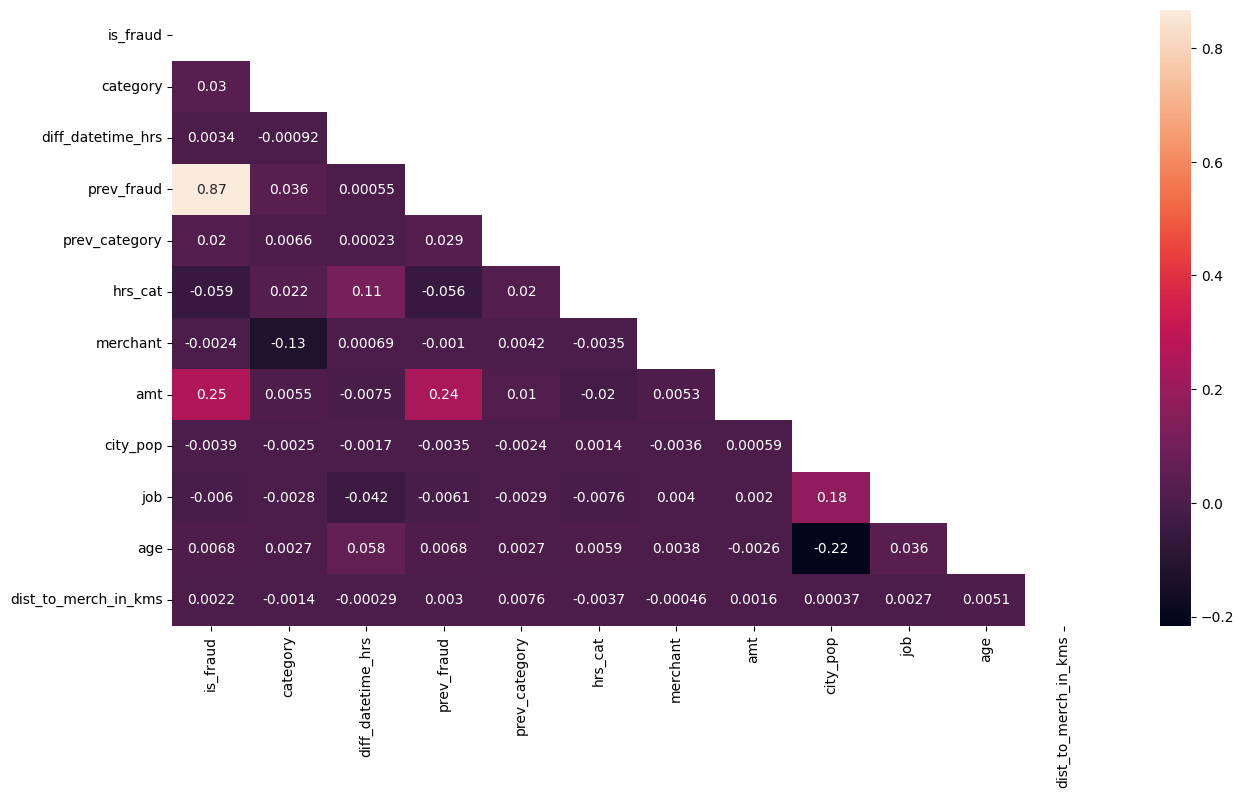

In [ ]:
quant = transactions_clean[['is_fraud', 'category', 'diff_datetime_hrs', 'prev_fraud',
       'prev_category', 'hrs_cat', 'merchant', 'amt', 'city', 'city_pop',
       'job', 'age', 'dist_to_merch_in_kms']]

corr = quant.corr()

mask = np.triu(np.ones_like(corr, dtype=bool))
fig, ax = plt.subplots(figsize=(15, 8))
ax = sns.heatmap(corr, mask=mask, annot=True)


In [ ]:
transaction_dt.columns

Index(['full_name', 'acct_num', 'cc_num', 'trans_num', 'category', 'is_fraud',
       'trans_date', 'trans_time', 'full_datetime', 'min_datetime',
       'lagged_datetime', 'diff_datetime', 'diff_datetime_days',
       'diff_datetime_hrs', 'diff_datetime_mins', 'prev_fraud',
       'prev_category', 'hrs_cat', 'merchant', 'amt', 'city', 'lat', 'long',
       'merch_lat', 'merch_long', 'city_pop', 'job', 'age',
       'dist_to_merch_in_kms'],
      dtype='object')

In [ ]:
transaction_clean.columns

Index(['full_name', 'acct_num', 'cc_num', 'trans_num', 'category', 'is_fraud',
       'trans_date', 'trans_time', 'full_datetime', 'min_datetime',
       'lagged_datetime', 'diff_datetime', 'diff_datetime_days',
       'diff_datetime_hrs', 'diff_datetime_mins', 'prev_fraud',
       'prev_category', 'hrs_cat', 'merchant', 'amt', 'city', 'lat', 'long',
       'merch_lat', 'merch_long', 'city_pop', 'job', 'age',
       'dist_to_merch_in_kms'],
      dtype='object')

In [ ]:
transactions_clean_onehot.columns

Index(['full_name', 'acct_num', 'cc_num', 'trans_num', 'is_fraud',
       'diff_datetime_hrs', 'prev_fraud', 'amt', 'city_pop', 'age',
       ...
       'city_San Pedro', 'city_Santa Rosa', 'city_Sorsogon', 'city_Surigao',
       'city_Tacloban', 'city_Taguig City', 'city_Tagum', 'city_Tandag',
       'city_Tarlac City', 'city_Valenzuela'],
      dtype='object', length=303)

In [ ]:
corr_cols = transactions_clean_onehot.drop(['full_name', 'acct_num', 'cc_num', 'trans_num'], axis =1).columns
corr_cols

Index(['is_fraud', 'diff_datetime_hrs', 'prev_fraud', 'amt', 'city_pop', 'age',
       'dist_to_merch_in_kms', 'category_entertainment',
       'category_food_dining', 'category_gas_transport',
       ...
       'city_San Pedro', 'city_Santa Rosa', 'city_Sorsogon', 'city_Surigao',
       'city_Tacloban', 'city_Taguig City', 'city_Tagum', 'city_Tandag',
       'city_Tarlac City', 'city_Valenzuela'],
      dtype='object', length=299)

In [ ]:
corr_cols[1:10]

Index(['diff_datetime_hrs', 'prev_fraud', 'amt', 'city_pop', 'age',
       'dist_to_merch_in_kms', 'category_entertainment',
       'category_food_dining', 'category_gas_transport'],
      dtype='object')

In [ ]:
quant = transactions_clean_onehot[corr_cols[0:20]]
corr = quant.corr()

corr.style.background_gradient(cmap='coolwarm')
# mask = np.triu(np.ones_like(corr, dtype=bool))
# fig, ax = plt.subplots(figsize=(15, 8))
# ax = sns.heatmap(corr, mask=mask, annot=True)

,is_fraud,diff_datetime_hrs,prev_fraud,amt,city_pop,age,dist_to_merch_in_kms,category_entertainment,category_food_dining,category_gas_transport,category_grocery_net,category_grocery_pos,category_health_fitness,category_home,category_kids_pets,category_misc_net,category_misc_pos,category_personal_care,category_shopping_net,category_shopping_pos
is_fraud,1.000000,0.003359,0.867523,0.253047,-0.003873,0.006848,0.002205,-0.018213,-0.024231,-0.004204,-0.007982,0.049135,-0.021586,-0.029455,-0.028456,0.066410,-0.017384,-0.022088,0.083852,0.011402
diff_datetime_hrs,0.003359,1.000000,0.000555,-0.007529,-0.001666,0.058437,-0.000291,-0.001567,0.002916,-0.002074,0.001024,0.004773,-0.000648,-0.003236,0.000276,-0.002578,0.001520,-0.001591,0.001898,0.002985
prev_fraud,0.867523,0.000555,1.000000,0.240889,-0.003528,0.006788,0.002974,-0.014930,-0.022271,-0.007190,-0.006947,0.028969,-0.019869,-0.028359,-0.027348,0.068146,-0.011295,-0.018883,0.082814,0.017713
amt,0.253047,-0.007529,0.240889,1.000000,0.000592,-0.002597,0.001649,-0.029646,0.013673,-0.002218,0.012031,0.040450,-0.036086,-0.017693,0.015226,0.016223,-0.010454,-0.038609,0.057154,-0.020064
city_pop,-0.003873,-0.001666,-0.003528,0.000592,1.000000,-0.215841,0.000368,0.002827,0.002534,0.003169,0.000300,-0.004019,0.000325,-0.002488,-0.000720,-0.004404,0.001608,0.002032,-0.005488,0.003454
age,0.006848,0.058437,0.006788,-0.002597,-0.215841,1.000000,0.005062,-0.002923,-0.002513,0.004846,-0.002711,0.002500,-0.005221,-0.001250,-0.001536,-0.001154,0.004300,-0.003566,0.002868,0.004521
dist_to_merch_in_kms,0.002205,-0.000291,0.002974,0.001649,0.000368,0.005062,1.000000,0.002194,0.002031,-0.004083,0.006041,-0.000544,0.000739,-0.002509,0.000931,0.001014,0.000862,-0.001689,0.000302,0.001686
category_entertainment,-0.018213,-0.001567,-0.014930,-0.029646,0.002827,-0.002923,0.002194,1.000000,-0.084872,-0.096500,-0.037719,-0.096770,-0.068288,-0.095626,-0.095882,-0.054283,-0.076712,-0.084485,-0.067609,-0.095765
category_food_dining,-0.024231,0.002916,-0.022271,0.013673,0.002534,-0.002513,0.002031,-0.084872,1.000000,-0.098843,-0.038634,-0.099120,-0.069946,-0.097948,-0.098210,-0.055601,-0.078574,-0.086537,-0.069250,-0.098090
category_gas_transport,-0.004204,-0.002074,-0.007190,-0.002218,0.003169,0.004846,-0.004083,-0.096500,-0.098843,1.000000,-0.043927,-0.112699,-0.079529,-0.111367,-0.111665,-0.063218,-0.089339,-0.098392,-0.078737,-0.111528


##### timeline plot

In [30]:
timeline_dt = transaction_dt[transaction_dt['full_name'].isin(['Aaron Chase', 'Aaron Suarez', 'Aaron Walker'])]
timeline_dt['full_name'].unique()

array(['Aaron Chase', 'Aaron Suarez', 'Aaron Walker'], dtype=object)

In [47]:
timeline_dt['trans_date'] = pd.to_datetime(timeline_dt['trans_date'])
timeline_dt['is_fraud'] = timeline_dt['is_fraud'].astype(str)
timeline_dt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3527 entries, 0 to 3526
Data columns (total 29 columns):
 #   Column                Non-Null Count  Dtype          
---  ------                --------------  -----          
 0   full_name             3527 non-null   object         
 1   acct_num              3527 non-null   float64        
 2   cc_num                3527 non-null   float64        
 3   trans_num             3527 non-null   object         
 4   category              3527 non-null   object         
 5   is_fraud              3527 non-null   object         
 6   trans_date            3527 non-null   datetime64[ns] 
 7   trans_time            3527 non-null   object         
 8   full_datetime         3527 non-null   datetime64[ns] 
 9   min_datetime          3527 non-null   datetime64[ns] 
 10  lagged_datetime       3524 non-null   datetime64[ns] 
 11  diff_datetime         3524 non-null   timedelta64[ns]
 12  diff_datetime_days    3524 non-null   float64        
 13  dif

In [33]:
source

,full_name,acct_num,cc_num,trans_num,category,is_fraud,trans_date,trans_time,full_datetime,min_datetime,...,amt,city,lat,long,merch_lat,merch_long,city_pop,job,age,dist_to_merch_in_kms
0,Aaron Chase,1.960530e+11,3.481480e+14,4f8a962f3dddc9f7e38511742f94f5c6,kids_pets,0,2020-01-01,22:20:55,2020-01-01 22:20:55,2020-01-01 22:20:55,...,115.58,San Jose del Monte,14.8139,121.0453,14.506379,120.512505,574089,Systems analyst,83,66.720087
1,Aaron Chase,1.960530e+11,3.481480e+14,d6f7186ff825d376de337b0736a8df51,misc_pos,0,2020-01-02,05:58:15,2020-01-02 05:58:15,2020-01-01 22:20:55,...,4.35,San Jose del Monte,14.8139,121.0453,15.614414,121.179912,574089,Systems analyst,83,89.750504
2,Aaron Chase,1.960530e+11,3.481480e+14,d369c21bde01d8936664b60ffe249966,shopping_pos,0,2020-01-02,06:20:53,2020-01-02 06:20:53,2020-01-01 22:20:55,...,4.65,San Jose del Monte,14.8139,121.0453,14.634738,120.816475,574089,Systems analyst,83,31.625560
3,Aaron Chase,1.960530e+11,3.481480e+14,449355d3afc7fbc8a0a9c4331b01baa0,personal_care,0,2020-01-02,19:30:42,2020-01-02 19:30:42,2020-01-01 22:20:55,...,32.87,San Jose del Monte,14.8139,121.0453,15.591447,120.376038,574089,Systems analyst,83,112.130879
4,Aaron Chase,1.960530e+11,3.481480e+14,99aa7b2fd8e3f8ed852fcd2736523ec4,kids_pets,0,2020-01-02,21:16:56,2020-01-02 21:16:56,2020-01-01 22:20:55,...,192.43,San Jose del Monte,14.8139,121.0453,15.723204,121.197265,574089,Systems analyst,83,101.931179
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3522,Aaron Walker,6.957000e+11,3.502010e+15,e28ad303a6f5415014fe844fafda72df,shopping_net,1,2021-03-16,23:57:12,2021-03-16 23:57:12,2021-03-16 02:09:49,...,1136.33,Cabanatuan City,15.4833,120.9667,15.176779,120.121480,302231,Acupuncturist,78,96.892936
3523,Aaron Walker,6.957000e+11,3.502010e+15,2b71c7ad9b291405e39bbe6fe96433c6,grocery_pos,1,2021-03-17,02:14:02,2021-03-17 02:14:02,2021-03-16 02:09:49,...,320.11,Cabanatuan City,15.4833,120.9667,14.727483,120.213929,302231,Acupuncturist,78,116.371124
3524,Aaron Walker,6.957000e+11,3.502010e+15,0d581ef312848f06be4589e13cb52d22,shopping_net,1,2021-03-17,22:02:52,2021-03-17 22:02:52,2021-03-16 02:09:49,...,1040.94,Cabanatuan City,15.4833,120.9667,14.839963,120.307400,302231,Acupuncturist,78,100.437321
3525,Aaron Walker,6.957000e+11,3.502010e+15,29543315f6a9e8246707dc7807b57091,shopping_net,1,2021-03-17,22:45:20,2021-03-17 22:45:20,2021-03-16 02:09:49,...,1061.87,Cabanatuan City,15.4833,120.9667,15.701281,121.743128,302231,Acupuncturist,78,86.693891


In [63]:
plt.figure(figsize=(15, 4))

import altair as alt
import datetime as dt
import pandas as pd

source = timeline_dt[['full_name', 'trans_date', 'is_fraud']][(timeline_dt['full_name'] == 'Aaron Chase') & \
    (timeline_dt['trans_date'] >= '2020-12-01') & (timeline_dt['trans_date'] <= '2020-12-31')]

alt.Chart(source).mark_point(size =100).encode(
    x=alt.X('trans_date', title = "Time",
    axis=alt.Axis(labelFontSize=14, labelFontStyle=alt.condition('datum.value == "Jeremy Corbyn"', alt.value('italic'), alt.value('bold')))),
    y=alt.Y('full_name', title = 'Artists',
    axis=alt.Axis(labelFontSize=14, labelFontStyle=alt.condition('datum.value == "Jeremy Corbyn"', alt.value('italic'), alt.value('bold')))),
    color=alt.Color('is_fraud', scale=alt.Scale(scheme='dark2'), legend = None)
    # color=alt.condition("datum.is_fraud == 1", alt.value('red'), alt.Color('in the chart'))
    #, labelFontStyle=alt.condition('datum.value == "Jeremy Corbyn"', alt.value('bold'), alt.value('italic')))
).properties(
    width = 600,
    height = 100,
    title = 'Album Release Timeline'
)

alt.Chart(...)

<Figure size 1500x400 with 0 Axes>